## Importing libraries

In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from itertools import permutations
import time

## Defining the problem

This problem is formulated as a robot team task allocation, sequencing, and scheduling optimization problem. A set of $N$ target locations (excluding a depot) is given, each associated with a processing time for the task to be perfprmed, and each connected by travel paths with known distances. A team consisting of $R$ identical robots is assumed to start from the depot. Robots are required to travel to targets and performe the task at that location. Travel times between locations are determined by the adjacency matrix of distances, and the mission completion time (makespan) is determined by both travel and processing durations. The decision variables are defined as: 

- assignment of target locations to robots
- sequence of visits for each robot

The objective is set to minimize the total mission completion time, subject to constraints on robot travel and precedence between travel and processing.

In [48]:
TARGETS = 8                 # number of target locations                
ROBOTS = 3                  # number of robots
MAX_PATH_LENGTH = 10        # cut-off distance between any two target locations
MAX_PROCESSING_TIME = 5     # cut-off processing time of any task

## Creating paths between target locations and depot

A symmetric adjacency matrix is created below to represent random travel distances between target locations, where 10% of the paths are removed (set to infinity) to indicate the absence of routes between those locations. Depot is connected to every other location.

In [49]:
# creating adjacency matrix consisting of distances between any two locations
Adj_Mat = np.zeros((TARGETS, TARGETS))

for i in range(TARGETS):
    Adj_Mat[i, i] = 0
    for j in range(i):
        if random.random() < 0.1 and j>0:                          # 10% chance to remove the path 
            Adj_Mat[i, j] = Adj_Mat[j, i] = np.inf
        else:
            Adj_Mat[i, j] = Adj_Mat[j, i] = np.random.randint(1, MAX_PATH_LENGTH)


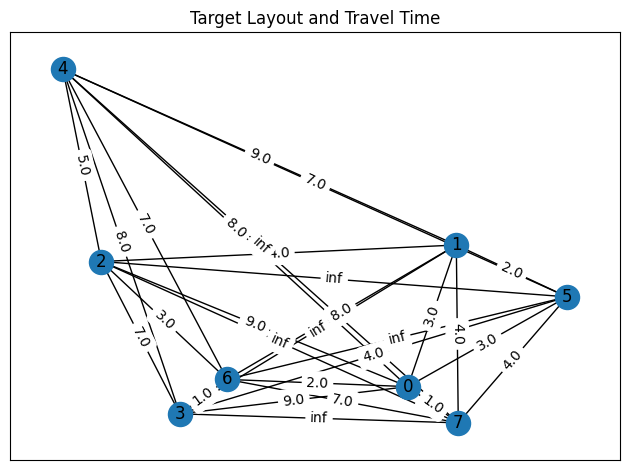

In [50]:
# visualizing the adjacency matrix using networkx
Adj_Mat_nx = nx.from_numpy_array(Adj_Mat)
edge_dict = {}
for i in Adj_Mat_nx.edges:
    edge_dict[i] = str(Adj_Mat[i])

nx.draw_networkx(Adj_Mat_nx, pos = nx.kamada_kawai_layout(Adj_Mat_nx))
nx.draw_networkx_edge_labels(Adj_Mat_nx, pos = nx.kamada_kawai_layout(Adj_Mat_nx), edge_labels=edge_dict)
plt.title('Target Layout and Travel Time')
plt.tight_layout()

## Generating processing times for each task randomly 

In [51]:
# Generate Processing Times
processing_times = np.random.randint(1, MAX_PROCESSING_TIME, TARGETS)
processing_times[0] = 0
print('Processing Times :', processing_times)

Processing Times : [0 4 1 1 2 2 3 2]


## Calculating mission time for each possible permuation

In [52]:
# Generate Combinations
node_perm = list(permutations(range(1,TARGETS), TARGETS - 1))
print('Total Permuations :', len(node_perm))

Total Permuations : 5040


In [54]:
mission_data = []
tic = time.time()

for node in node_perm:
    time_taken = 0
    finished_task = []
    robot_status_order = ['travel', 'process', 'idle']

    marked_target = []

    # Initialize robot states
    robot = {}
    for i in range(ROBOTS):
        robot[i] = {
            'current_node': 0,
            'status': 'idle',
            'pre_node': [0],
            'next_node': -1,
            'finish_time': 0
        }

    robot = pd.DataFrame(robot).transpose()
    # Cast finish_time to float to allow np.inf
    robot['finish_time'] = robot['finish_time'].astype(float)

    # Assign initial targets to robots and set status to travel
    for i in range(ROBOTS):
        robot.loc[i, 'status'] = 'travel'
        robot.loc[i, 'next_node'] = node[i]
        robot.loc[i, 'finish_time'] = time_taken + Adj_Mat[robot.loc[i, 'current_node'], robot.loc[i, 'next_node']]
        marked_target.append(node[i])

    # Map status to number for easier cycling through states
    robot['status_num'] = robot['status'].map(lambda x: robot_status_order.index(x))

    # Main loop: run until all tasks except one are finished
    while len(finished_task) < TARGETS - 1:
        time_taken = robot.finish_time.min()  # Next event time

        # Update robots that have finished their current action
        for i in range(ROBOTS):
            if robot.loc[i, 'finish_time'] == time_taken:
                current_status_num = robot.loc[i, 'status_num']

                if current_status_num == 0:  # travel → process
                    robot.loc[i, 'status_num'] = 1
                    robot.loc[i, 'current_node'] = robot.loc[i, 'next_node']
                    robot.loc[i, 'next_node'] = -1
                    # Processing time for current node
                    robot.loc[i, 'finish_time'] = time_taken + processing_times[robot.loc[i, 'current_node']]

                elif current_status_num == 1:  # process → idle (task done)
                    # Record finished task
                    robot.loc[i, 'pre_node'].append(robot.loc[i, 'current_node'])
                    finished_task.append(robot.loc[i, 'current_node'])

                    robot.loc[i, 'status_num'] = 2  # idle
                    robot.loc[i, 'finish_time'] = np.inf  # no active task
                    robot.loc[i, 'current_node'] = 0

                    # Assign next target if available
                    if len(marked_target) < TARGETS - 1:
                        next_task = node[len(marked_target)]
                        robot.loc[i, 'next_node'] = next_task
                        robot.loc[i, 'status_num'] = 0  # travel
                        robot.loc[i, 'finish_time'] = time_taken + Adj_Mat[robot.loc[i, 'current_node'], next_task]
                        marked_target.append(next_task)

                elif current_status_num == 2:
                    # idle: no action, wait for assignment
                    robot.loc[i, 'finish_time'] = np.inf

        # Update robot status strings from status_num
        robot['status'] = robot['status_num'].map(lambda x: robot_status_order[x])

    # Collect path and time info
    current_path_para = {'Path Perm': node, 'Time Taken': time_taken}
    for i in range(ROBOTS):
        current_path_para[f'Robot_path_{i}'] = robot.loc[i, 'pre_node']

    mission_data.append(current_path_para)

toc = time.time()
total_time_elapsed = toc - tic
print(f'Optimized Path calculated in {total_time_elapsed:.3f} seconds')


Optimized Path calculated in 119.884 seconds


In [55]:
# returning top 10 evaluations
mission_data = pd.DataFrame(mission_data)
mission_data = mission_data.sort_values(by='Time Taken', ascending=True)
mission_data.head(10)

,Path Perm,Time Taken,Robot_path_0,Robot_path_1,Robot_path_2
26,"(1, 2, 4, 3, 6, 5, 7)",18.0,"[0, 1, 3]","[0, 2, 6, 7]","[0, 4, 5]"
27,"(1, 2, 4, 3, 6, 7, 5)",18.0,"[0, 1, 3]","[0, 2, 6]","[0, 4, 7, 5]"
28,"(1, 2, 4, 3, 7, 5, 6)",18.0,"[0, 1, 3]","[0, 2, 7, 6]","[0, 4, 5]"
29,"(1, 2, 4, 3, 7, 6, 5)",18.0,"[0, 1, 3]","[0, 2, 7, 5]","[0, 4, 6]"
5000,"(7, 6, 4, 2, 3, 1, 5)",18.0,"[0, 7, 2, 5]","[0, 6, 3]","[0, 4, 1]"
5006,"(7, 6, 4, 3, 2, 1, 5)",18.0,"[0, 7, 3, 5]","[0, 6, 2]","[0, 4, 1]"
5013,"(7, 6, 4, 5, 2, 3, 1)",18.0,"[0, 7, 5, 3]","[0, 6, 2]","[0, 4, 1]"
5015,"(7, 6, 4, 5, 3, 2, 1)",18.0,"[0, 7, 5, 2]","[0, 6, 3]","[0, 4, 1]"
1488,"(3, 1, 5, 2, 4, 6, 7)",18.0,"[0, 3, 6, 7]","[0, 1, 4]","[0, 5, 2]"
1489,"(3, 1, 5, 2, 4, 7, 6)",18.0,"[0, 3, 7, 6]","[0, 1, 4]","[0, 5, 2]"
